<a href="https://colab.research.google.com/github/allen-99/diploma/blob/main/learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 31.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=c0222c1fe75a638e5bf7565457a4f7d53dc225fddab46f7289dcdf1d415145a5
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
from datetime import datetime
import pytz
import warnings
import string

import pandas as pd

import spacy
from spacy.matcher import Matcher

import pymorphy2

import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/content/sample_data/reviews_yandex_suki.csv')
data.columns = ['text', 'rating', 'date']
data = data.drop_duplicates(subset=['text'])
data

,text,rating,date
0,"Очень порадовал океанариум, большим разнообраз...",5,2022-08-15T18:37:43.814Z
1,Полный восторг! Объемная и разнообразная экспо...,5,2022-09-10T11:19:37.237Z
2,Прекрасный океанариум! Великолепные экспозиции...,5,2023-03-28T06:49:18.890Z
3,"Идеальное место, нет нареканий вообще никаких....",5,2022-09-10T11:52:16.742Z
4,Очень понравилось в океанариуме. Есть на что п...,5,2022-07-13T19:14:44.275Z
...,...,...,...
3404,Очень хорошая коллекция рыб. Но самые классные...,5,2023-01-08T10:21:05.052Z
3405,"Красиво, все хорошо и интересно сделано. Кормл...",5,2022-11-06T10:57:52.834Z
3407,"Шикарное место. Все сделано на высшем уровне,...",5,2022-01-22T13:51:45.238Z
3408,"Отличный, большой, очень много экспозиции . Пе...",5,2023-01-11T21:46:11.120Z


In [ ]:
for index, row in data.iterrows():
  try:
    date = datetime.strptime(row['date'], '%Y-%m-%dT%H:%M:%S.%fZ')
  except:
    date = datetime.strptime(row['date'], '%Y-%m-%dT%H:%M:%S%fZ')
  row['date'] = date

data = data.sort_values('date')
data['date'] = pd.to_datetime(data['date']).dt.date
result = data.loc[data['rating'] == 0]
data = data.drop(result.index)

In [ ]:
pretext = ['в', 'на', 'о', 'с', 'у', 'к', 'по', 'за', 'из', 'от', 'до', 'перед', 'через', 'среди', 'между', 'вокруг', 'около', 'возле', 'над', 'под', 'внизу', 'вверху', 'вглубь', 'вдоль', 'насчет', 'со', 'путем']
unions = ['а', 'и', 'но', 'или', 'да', 'как', 'так', 'чем', 'ли', 'же', 'только', 'хоть', 'раз', 'даже', 'после', 'пока', 'тогда', 'хотя', 'если', 'поскольку', 'потому', 'ибо', 'оттого', 'затем', 'ведь', 'чтобы', 'чтоб', 'словно', 'будто', 'точно', 'когда', 'как только', 'также', 'таким образом', 'следовательно', 'в результате', 'итак', 'дабы']

stop_words = unions + pretext

In [ ]:
def create_bag_of_words(text):
  bigrams_doc = []
  trigrams_doc = []
  filtered_doc = []

  doc = word_tokenize(text, language='russian')
  tokens = [word.lower() for word in doc if word not in string.punctuation]
  filtered_words = [word for word in tokens if word.lower() not in stop_words]
  lemma_words = []
  for word in filtered_words:
    parses = morph.parse(word)
    lemma = parses[0].normal_form
    lemma_words.append(lemma)
  filtered_doc.append(filtered_words) 
  bigrams = ngrams(lemma_words, 2)
  trigrams = ngrams(lemma_words, 3)

  bag_of_words = {}
  for token in lemma_words:
      bag_of_words[token] = bag_of_words.get(token, 0) + 1    
  return bag_of_words


In [ ]:
texts = data['text']
labels = data['rating']

In [ ]:
vectorizer = TfidfVectorizer(analyzer=create_bag_of_words)

X = vectorizer.fit_transform(texts)
y = labels.to_numpy()

In [ ]:
vectorizer1 = CountVectorizer(analyzer=create_bag_of_words)

X1 = vectorizer1.fit_transform(texts)
y1 = labels.to_numpy()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

params = {'alpha': 0.6, 'class_prior': None, 'fit_prior': False}

clf = MultinomialNB(**params)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')

print("Precision: {:.2f}".format(precision))
print('Accuracy: {:.2f}'.format(accuracy))

Precision: 0.61
Accuracy: 0.69


In [ ]:
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=48)

params = {'alpha': 0.6, 'class_prior': None, 'fit_prior': False}

clf = MultinomialNB(**params)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')

print("Precision: {:.2f}".format(precision))
print('Accuracy: {:.2f}'.format(accuracy))

Precision: 0.66
Accuracy: 0.71


In [ ]:
from sklearn.model_selection import cross_validate, KFold
import numpy as np

random_state_values = range(1,21)
kf = KFold(n_splits=20, shuffle=True)
scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores = cross_validate(clf, X, y, cv=kf, scoring=scoring)
df_scores = pd.DataFrame(scores)
index_dict = range(1,21)
df_scores['KFold'] = index_dict
best_accuracy_index = np.argmax(scores['test_accuracy'])
best_random_state = random_state_values[best_accuracy_index]
best_random_state

18

In [ ]:
counts = data['rating'].value_counts()
counts = counts.sort_index()
count_pre = [(count/len(data['rating'])*100) for count in counts] 
count_pre_reverse = [(1/count*100) for count in count_pre] 

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import numpy as np

kf = KFold(n_splits=best_random_state, shuffle=True)

params = {
    'alpha': np.arange(0, 1.1, 0.1),
    'fit_prior': [True, False],
    'class_prior': [None, count_pre, count_pre_reverse],
}


grid = GridSearchCV(clf, params, cv=kf)
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Accuracy:", grid.best_score_)

Best parameters: {'alpha': 0.6000000000000001, 'class_prior': None, 'fit_prior': False}
Accuracy: 0.673802242609582


In [ ]:
accuracy_max_i = 0
accuracy_max_value = 0

for i in range(1,100):
  X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=i)

  params = {'alpha': 0.6, 'class_prior': None, 'fit_prior': False}

  clf = MultinomialNB(**params)
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)
  y_score = clf.predict_proba(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  if accuracy_max_value < accuracy:
    accuracy_max_value = accuracy
    accuracy_max_i = i
    
print('Random state: ', accuracy_max_i ,' Accuracy: ', accuracy_max_value)

Random state:  48  Accuracy:  0.7113752122241087


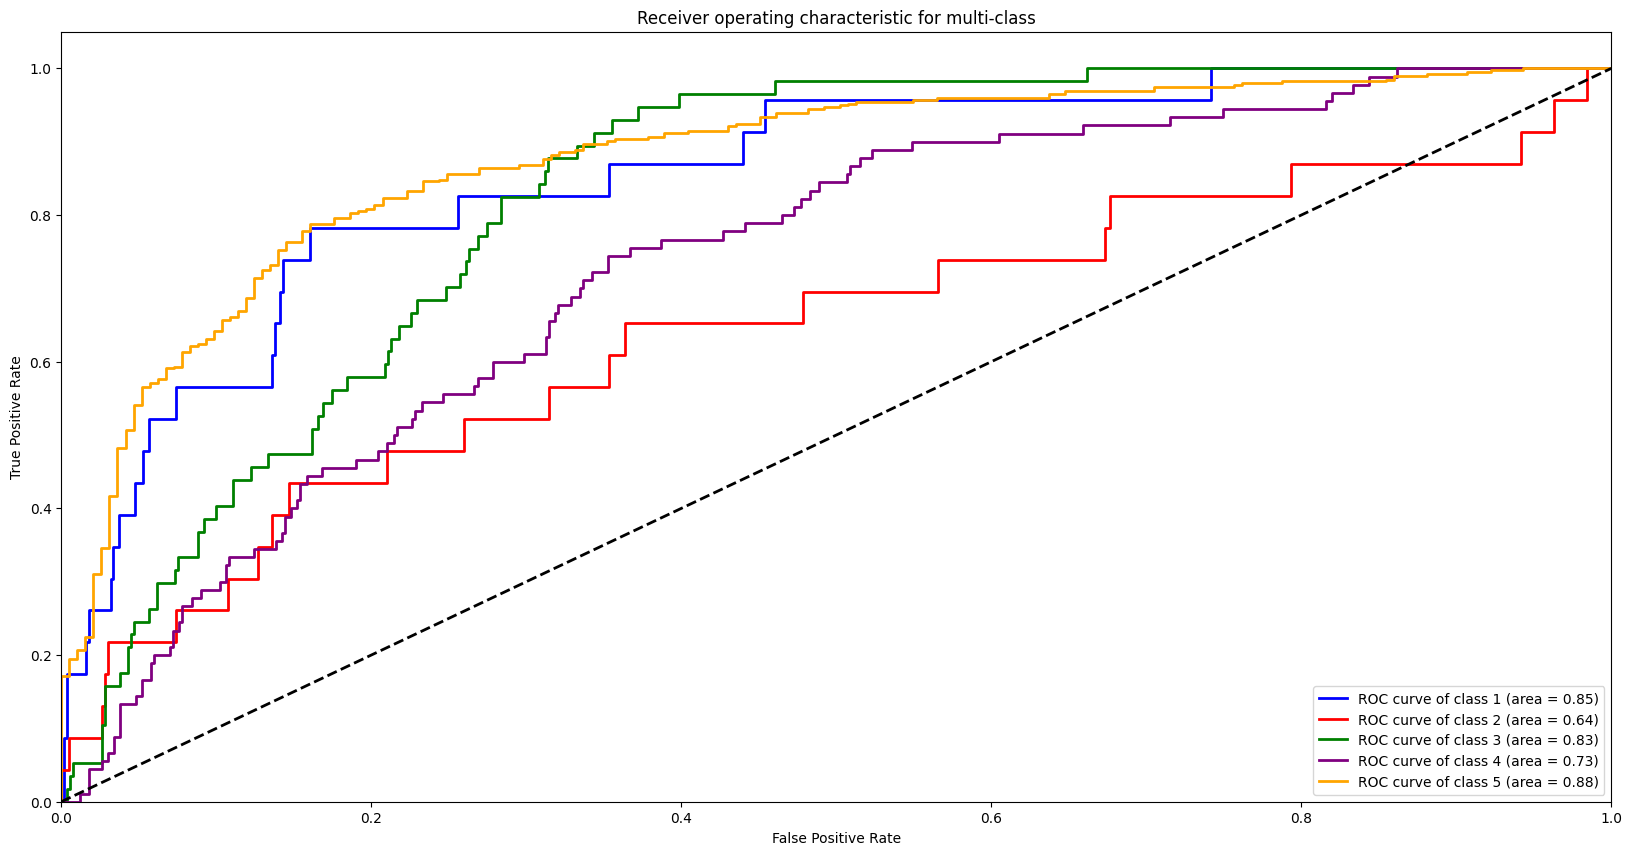

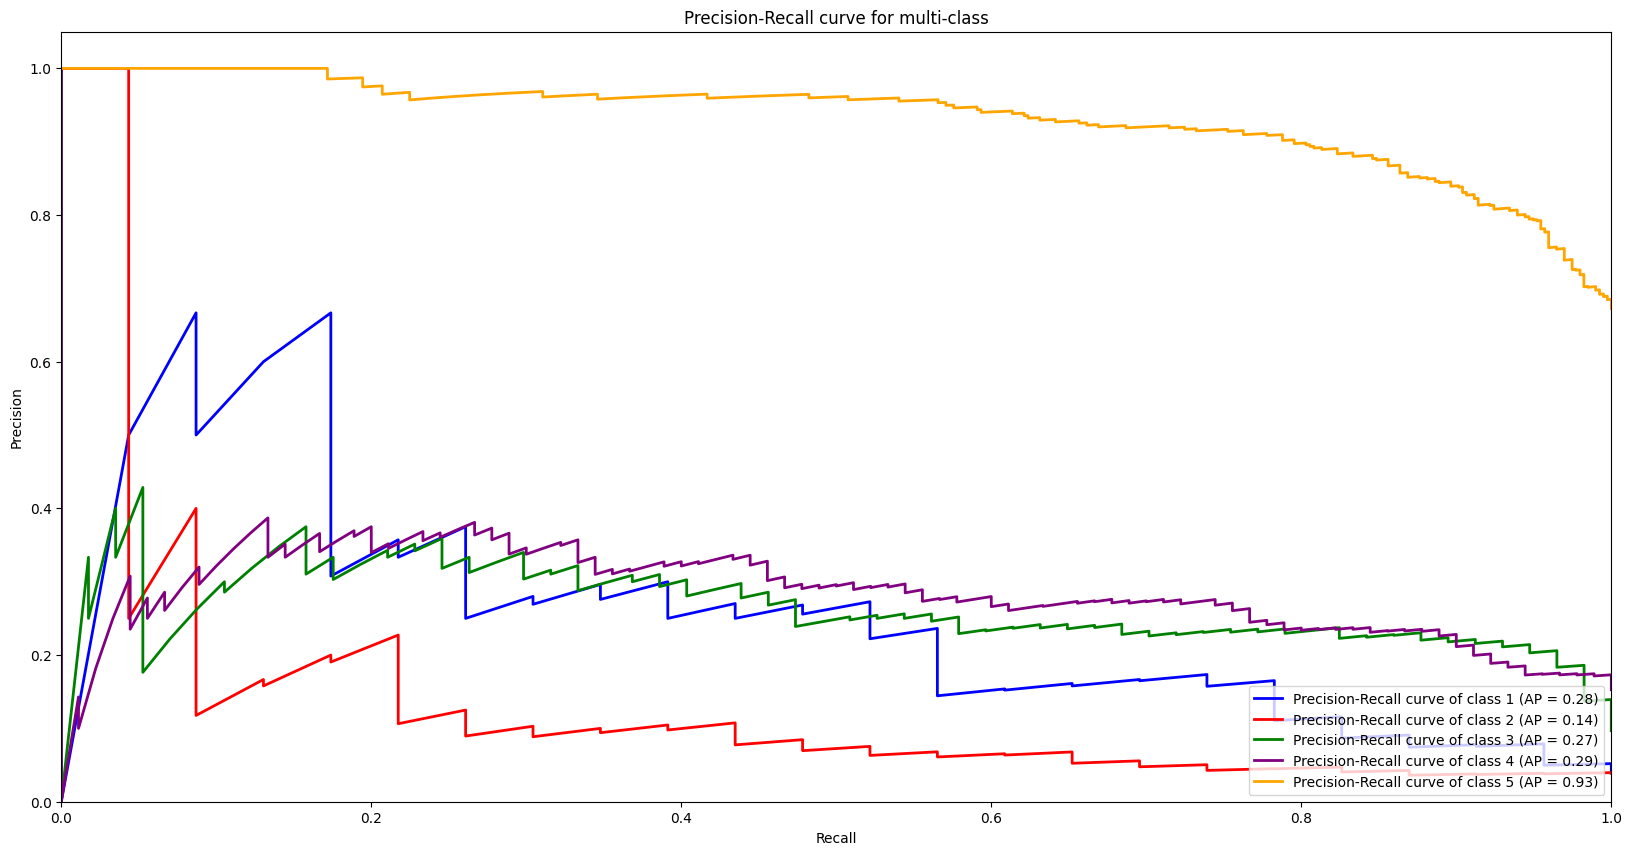

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_true = label_binarize(y_test, classes=[1, 2, 3, 4, 5])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(20, 10))
lw = 2
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i + 1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

precision = dict()
recall = dict()
average_precision = dict()
for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_score[:, i])

# Строим Precision-Recall кривую для каждого класса
plt.figure(figsize=(20, 10))
lw = 2
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(5), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='Precision-Recall curve of class {0} (AP = {1:0.2f})'
             ''.format(i+1, average_precision[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for multi-class')
plt.legend(loc="lower right")
plt.show()